In [1]:
import pandas as pd
import torch
torch.manual_seed(0)
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os
import copy
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import WeightedRandomSampler, DataLoader

from dataloader import VAEMVTSDataLoader

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [2]:
def calc_accuracy(ypred,y):
    toppred = ypred.argmax(1, keepdim = True)
    correct = toppred.eq(y.view_as(toppred)).sum()
    return correct

def gen_weightedsampler(datasets):
    target = datasets.labels
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    return WeightedRandomSampler(samples_weight, len(samples_weight))
    

In [3]:
csv_path = 'goodreduced-vae.csv'
trainsd = VAEMVTSDataLoader(csv_path,splittype='train')
testsd = VAEMVTSDataLoader(csv_path,splittype='test')
#

batch_size = 64


# Creating PT data samplers and loaders:
train_sampler = gen_weightedsampler(trainsd)
valid_sampler = gen_weightedsampler(testsd)

train_loader = torch.utils.data.DataLoader(trainsd, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(testsd, batch_size=batch_size)#, sampler=valid_sampler)

In [4]:
label = []
for batch_idx, (data, ytrue,slen) in enumerate(train_loader):
    #data = Variable(data)
    label += ytrue.numpy().tolist()

labelv = []
for batch_idx, (data, ytrue,slen) in enumerate(validation_loader):
    #data = Variable(data)
    labelv += ytrue.numpy().tolist()

In [5]:
print(str(pd.DataFrame(data = label).value_counts())+'\n'+str(pd.DataFrame(data = labelv).value_counts()))

0    3456
1    3372
dtype: int64
0    2980
1     383
dtype: int64


In [6]:
pd.DataFrame(data = label).value_counts()[1]

3372

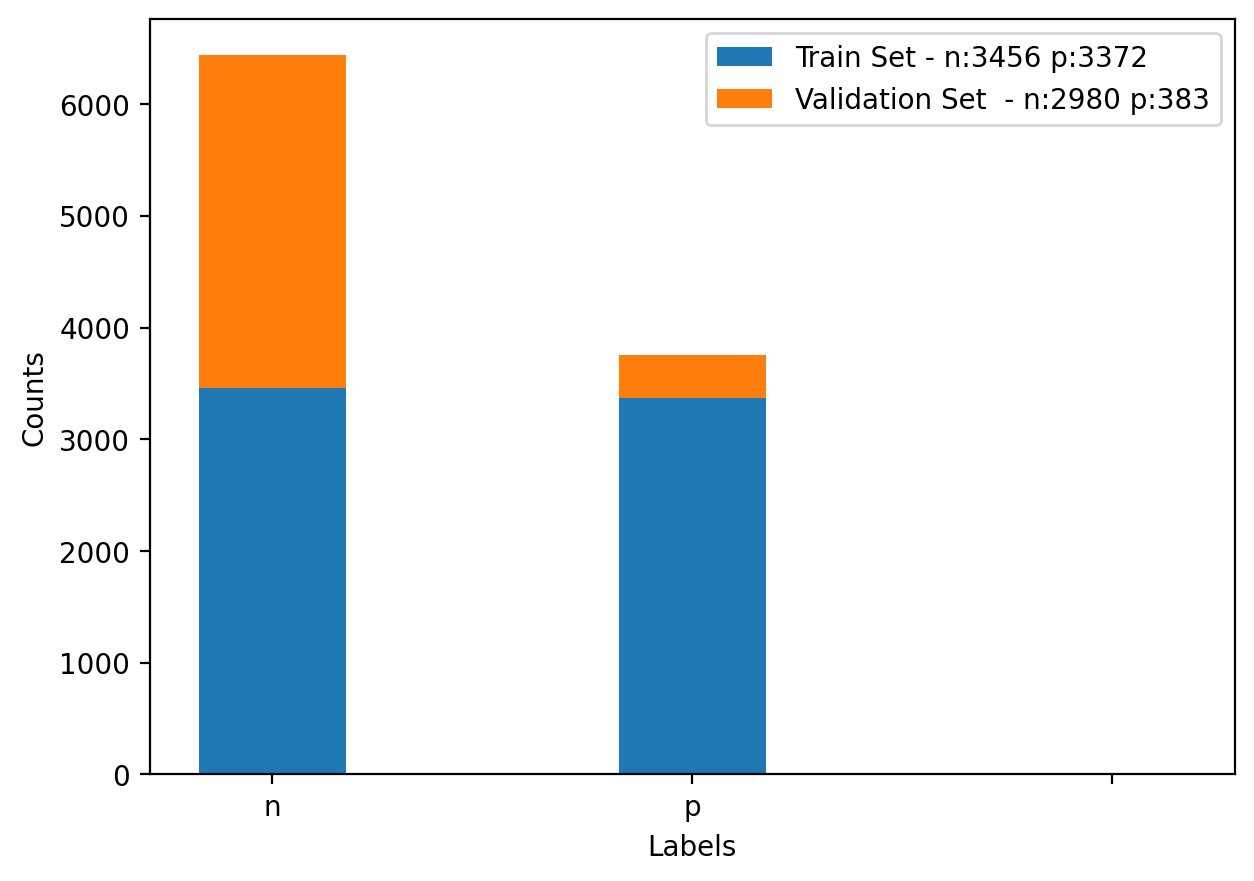

In [7]:
train = (pd.DataFrame(data = label).value_counts()[0],pd.DataFrame(data = label).value_counts()[1], 0)
valid = (pd.DataFrame(data = labelv).value_counts()[0],pd.DataFrame(data = labelv).value_counts()[1],0)

ind = np.arange(3)
width = 0.35

fig = plt.subplots(figsize=(7,5))
p1 = plt.bar(ind, train, width)
p2 = plt.bar(ind, valid, width, bottom=train)

plt.ylabel('Counts')
plt.xlabel('Labels')
plt.xticks(ind, ('n','p', None))
plt.legend((p1[0],p2[0]),('Train Set - n:'+str(train[0])+' p:'+str(train[1]), 'Validation Set  - n:'+str(valid[0])+' p:'+str(valid[1])), loc = 'upper right')
plt.show()


In [8]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 5 # number of hidden states
        self.n_layers = 2 # number of LSTM layers (stacked)
    
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True,
                                 bidirectional = True,
                                 dropout = 0.2)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        #self.l_linear1 = torch.nn.Linear(self.n_hidden*self.seq_len, )#outputshape
        nhid = 2
        self.dropout = torch.nn.Dropout(0.3)
        #print(self.n_hidden*self.seq_len*2)
        self.l_linear1 = torch.nn.Linear(self.n_hidden*self.seq_len*2, nhid)#outputshape
        
    
    def forward(self, data, slen):        
        batch_size, seq_len, _ = data.size()
        hidden_state0 = torch.zeros(self.n_layers*2,batch_size,self.n_hidden).cuda()
        cell_state0 = torch.zeros(self.n_layers*2,batch_size,self.n_hidden).cuda()

        slen, idx_sort = np.sort(slen)[::-1], np.argsort(-slen)
        idx_unsort = np.argsort(idx_sort)
        #idx_sort = torch.from_numpy(idx_sort)
        data = data.index_select(0,Variable(idx_sort).cuda())
        #print(slen)
        data_packed = pack_padded_sequence(data,slen.copy(), batch_first=True)
        #print(prevstate[0].shape)
        lstm_out, (hidden,cell) = self.l_lstm(data_packed.float(),(hidden_state0,cell_state0))
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        
        data = pad_packed_sequence(lstm_out, total_length=seq_len,batch_first=True)[0]

        #idx_unsort = torch.from_numpy(idx_sort)
        data = data.index_select(0, Variable(idx_unsort).cuda())
        out = data.contiguous().view(batch_size,-1)
        #print(out.shape)
        #print(data.shape,out.shape)
        out = self.dropout(out)
        out = self.l_linear1(out)
        #out = F.relu(out)
        #out = self.l_linear(out)
        out = torch.sigmoid(out)
        return out

In [9]:
dataiter = iter(train_loader)
data, y,slen = dataiter.next()

# create NN
mv_net = MV_LSTM(data.shape[2],data.shape[1]).cuda()
print(mv_net)
criterion = torch.nn.CrossEntropyLoss(reduction='mean') 
optimizer = torch.optim.Adam(mv_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300,500])

MV_LSTM(
  (l_lstm): LSTM(130, 5, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (l_linear1): Linear(in_features=260, out_features=2, bias=True)
)


In [10]:
epochs = 700
best_loss =float('inf')
firsttime = True
ep, trainloss, validloss = [],[],[]
tracc, tsacc = [],[]
for e in range(epochs):
    mv_net.train()
    trloss = 0
    trnacc = 0
    trtot = 0
    for batch_idx, (data, ytrue,slen) in enumerate(train_loader):
        data = Variable(data).cuda()
        optimizer.zero_grad()
        #print('run')
        #if firsttime:
        
        #    firsttime = False
        #state = (stateh[:,:data.shape[0],:].detach(), statec[:,:data.shape[0],:].detach())
        ypred = mv_net(data,slen)
        #state = (stateh.detach(), statec.detach())
        #state[1] = state[1].detach() 
        loss = criterion(ypred, ytrue.cuda())
        acc = calc_accuracy(ypred, ytrue.cuda())
        loss.backward()
        optimizer.step()
        trloss += loss.item()
        trnacc += acc.item()
        trtot += ytrue.shape[0] 
    trainacc = trnacc/trtot

    mv_net.eval()
    valloss = 0
    vacc = 0
    tstot=0
    with torch.no_grad():
        for data, ytrue,slen in validation_loader:
            data = Variable(data).cuda()
            ypred = mv_net(data,slen) 
            loss = criterion(ypred, ytrue.cuda())
            acc = calc_accuracy(ypred, ytrue.cuda())
            valloss += loss.item()
            vacc += acc.item()
            tstot += ytrue.shape[0]
        valacc = vacc/tstot


    if valloss < best_loss:
        best_loss = valloss
        best_e = e
        best_mv_net = copy.deepcopy(mv_net)

    to_print = "Epoch[{}/{}], Train Loss: {:.4f} | Valid Loss: {:.4f} | Train Acc: {:.4f} | Valid Acc: {:.4f}".format(e+1,
    epochs, trloss, valloss, trainacc, valacc)
    scheduler.step()

    print(to_print)
    ep+=[e]
    trainloss += [trloss]
    validloss += [valloss]
    tracc+= [trainacc]
    tsacc += [valacc]

Epoch[1/700], Train Loss: 72.7347 | Valid Loss: 34.9146 | Train Acc: 0.5680 | Valid Acc: 0.8156
Epoch[2/700], Train Loss: 71.5562 | Valid Loss: 32.5138 | Train Acc: 0.6113 | Valid Acc: 0.8156
Epoch[3/700], Train Loss: 71.1080 | Valid Loss: 32.0786 | Train Acc: 0.6057 | Valid Acc: 0.7321
Epoch[4/700], Train Loss: 70.4716 | Valid Loss: 30.7706 | Train Acc: 0.6139 | Valid Acc: 0.8156
Epoch[5/700], Train Loss: 70.6802 | Valid Loss: 31.0992 | Train Acc: 0.6081 | Valid Acc: 0.7321
Epoch[6/700], Train Loss: 69.5328 | Valid Loss: 29.6941 | Train Acc: 0.6213 | Valid Acc: 0.8156
Epoch[7/700], Train Loss: 69.2800 | Valid Loss: 30.8704 | Train Acc: 0.6233 | Valid Acc: 0.7321
Epoch[8/700], Train Loss: 69.6752 | Valid Loss: 30.1461 | Train Acc: 0.6195 | Valid Acc: 0.7321
Epoch[9/700], Train Loss: 68.8859 | Valid Loss: 32.3915 | Train Acc: 0.6299 | Valid Acc: 0.7315
Epoch[10/700], Train Loss: 68.3162 | Valid Loss: 28.9897 | Train Acc: 0.6362 | Valid Acc: 0.8145
Epoch[11/700], Train Loss: 68.7933 | Va

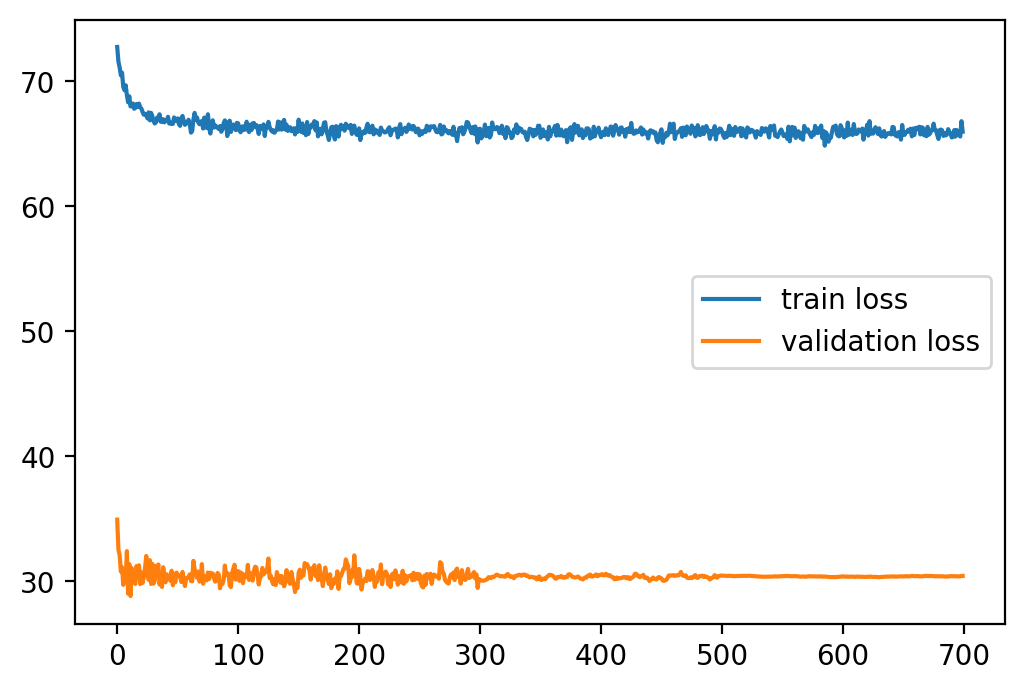

In [13]:
plt.plot(ep,trainloss, label = 'train loss')
plt.plot(ep, validloss, label = 'validation loss')
plt.legend()
plt.show()

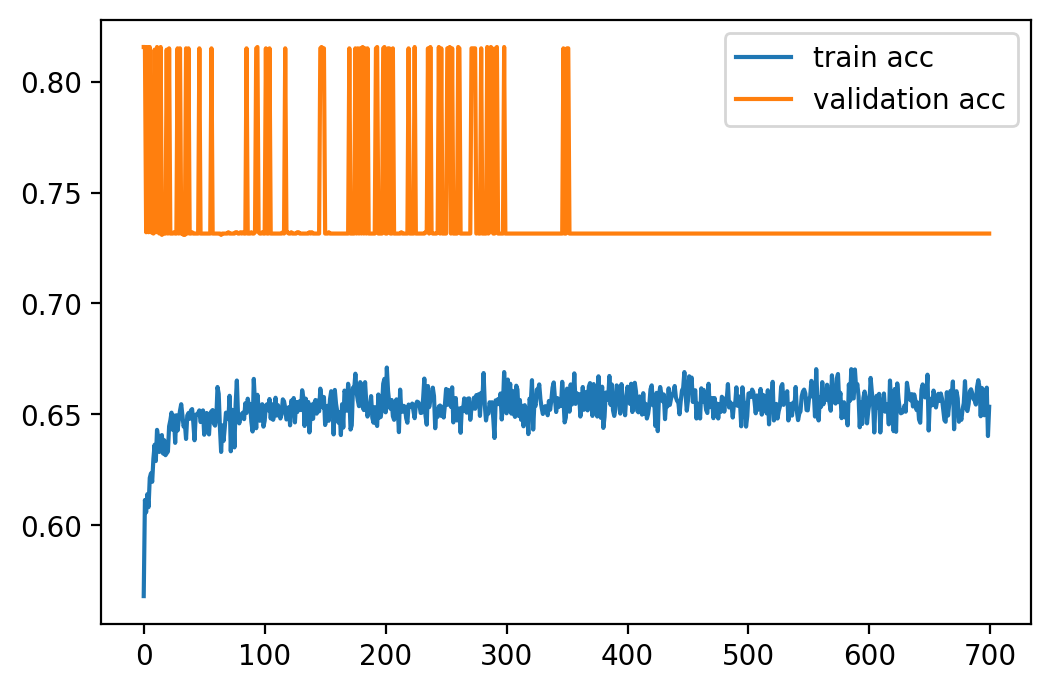

In [14]:
plt.plot(ep,tracc, label = 'train acc')
plt.plot(ep, tsacc, label = 'validation acc')
plt.legend()
plt.show()

In [15]:
nb_classes = 2
conf_matrix = torch.zeros(nb_classes,nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
i=0

y_truths = np.array([])
with torch.no_grad():
    for data, ytrue,slen in validation_loader:
        data = Variable(data).cuda()
        ytrue = ytrue.cuda()
        #state = mv_net.init_hidden(data.size(0))
        ypred = mv_net(data,slen) 
        _,preds = torch.max(ypred, 1)
        y_truths = np.append(y_truths,ytrue.cpu().numpy())
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        if i == 0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis = 0)
        i+=1
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_truths, y_predictions)
    

In [16]:
conf_matrix

array([[2167,  813],
       [  90,  293]])

In [17]:
print(np.diag(conf_matrix)/conf_matrix.sum(1))
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))

[0.72718121 0.76501305]


Text(0.5, 1.0, 'class n: 0.727 | class p: 0.765')

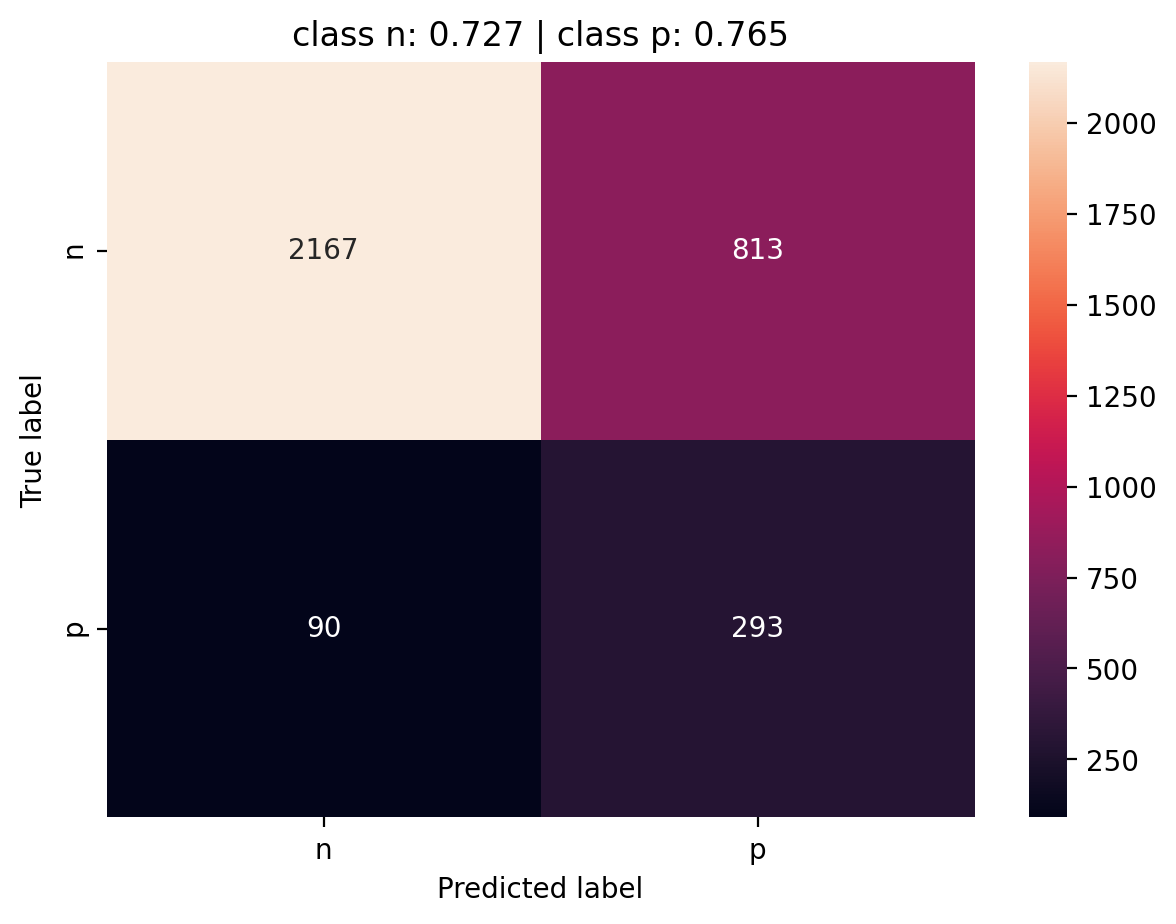

In [18]:
import pandas as pd
import seaborn as sn
df_cm = pd.DataFrame(conf_matrix, index = [i for i in "np"],
                  columns = [i for i in "np"])
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class n: {:0.3f} | class p: {:0.3f}'.format(accs[0],accs[1]))

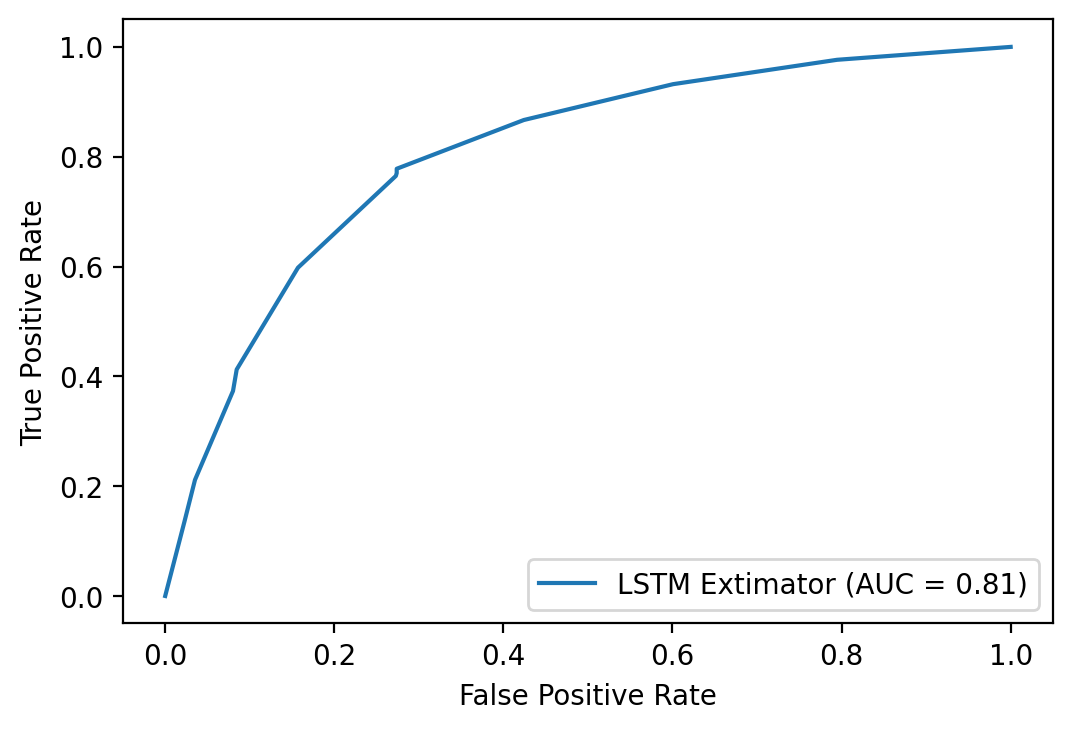

In [19]:
from sklearn import metrics

fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:,1])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'LSTM Extimator')
display1.plot()
plt.show()

In [20]:
nb_classes = 2
conf_matrix = torch.zeros(nb_classes,nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
i=0

y_truths = np.array([])
with torch.no_grad():
    for data, ytrue,slen in validation_loader:
        data = Variable(data).cuda()
        ytrue = ytrue.cuda()
        #state = best_mv_net.init_hidden(data.size(0))
        ypred = best_mv_net(data,slen) 
        _,preds = torch.max(ypred, 1)
        y_truths = np.append(y_truths,ytrue.cpu().numpy())
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        if i == 0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis = 0)
        i+=1
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_truths, y_predictions)
    

/home/vip/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:664: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  result = _VF.lstm(input, batch_sizes, hx, self._flat_weights, self.bias,


[0.84194631 0.61096606]


Text(0.5, 1.0, 'class n: 0.842 | class p: 0.611')

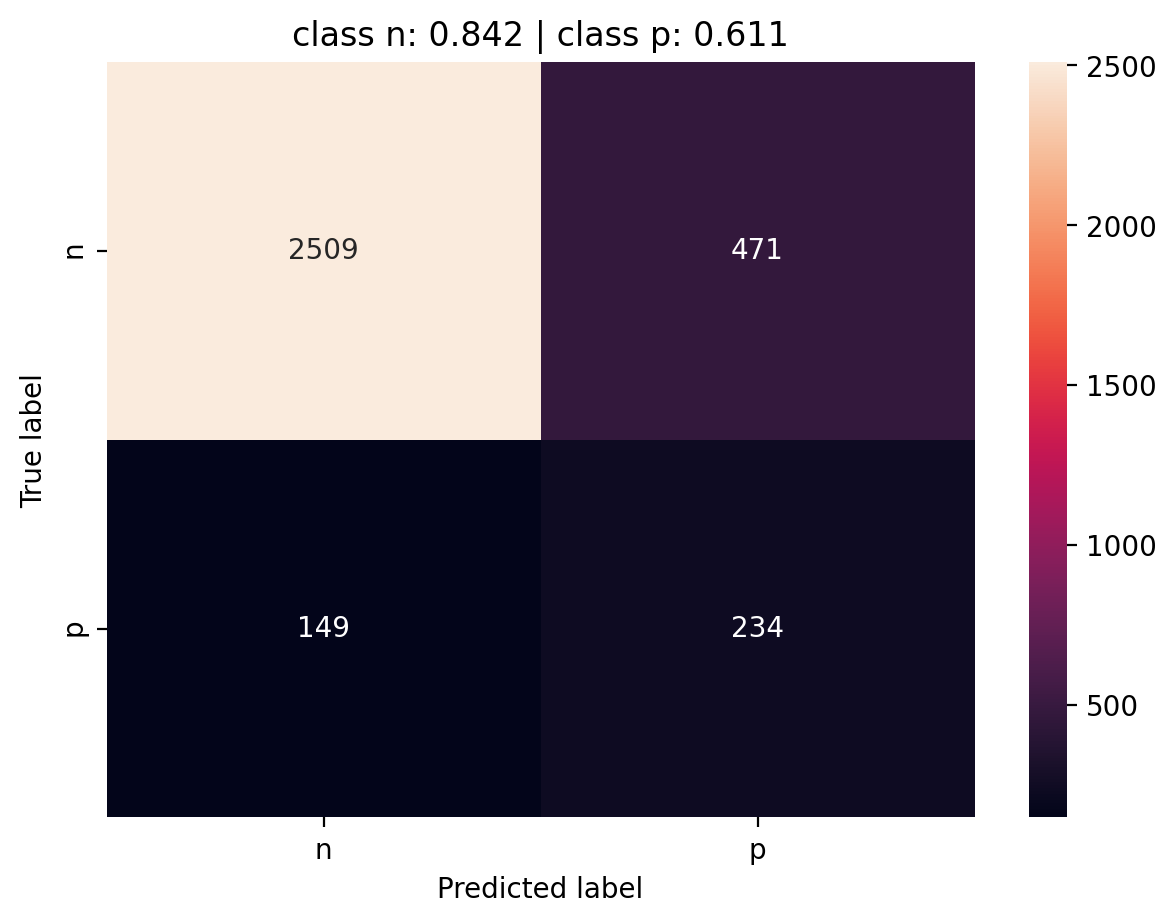

In [21]:
import pandas as pd
import seaborn as sn
print(np.diag(conf_matrix)/conf_matrix.sum(1))
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in "np"],
                  columns = [i for i in "np"])
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class n: {:0.3f} | class p: {:0.3f}'.format(accs[0],accs[1]))

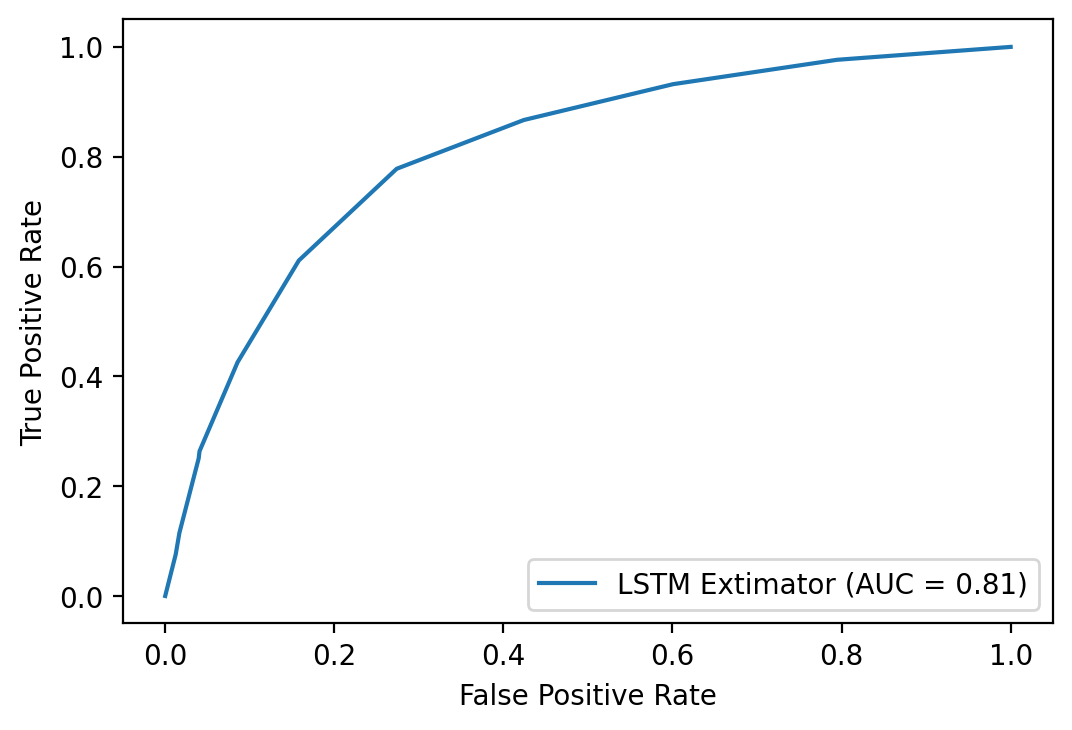

In [22]:
from sklearn import metrics

fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:,1])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'LSTM Extimator')
display1.plot()
plt.show()

In [19]:
slen

tensor([7, 2, 2, 3, 6, 6, 2, 2, 6, 6, 3, 4, 2, 5, 2, 4, 5, 2, 4, 5, 3, 5, 2, 6])